In [93]:
import warnings
warnings.filterwarnings("ignore")

In [94]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [95]:
np.set_printoptions(suppress=True)
pd.set_option("display.float_format", lambda x: '%2f' %x)

In [96]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)',    fontsize=16)
    plt.grid(True)

### Data Preprocessing

In [97]:
data = pd.read_csv("data.csv")

In [98]:
data.shape

(22260, 65)

In [99]:
training_data = data.loc[data["Year"]==1]
testing_data  = data.loc[data["Year"]==2]

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples:  { testing_data.shape[0]}")

No. of training examples: 10585
No. of testing examples:  11675


In [100]:
x_train = training_data.drop(["Quit", "ID", "Year", "TotalDay",
                              "LastMonthSalary", "LastMonthSalaryBonus", "LiveDormRatio",
                              "LastMonthSalaryBonusPct", "LastMonthSalaryPct", "LeavePeakSeason"], axis=1)

x_test  =  testing_data.drop(["Quit", "ID", "Year", "TotalDay",
                              "LastMonthSalary", "LastMonthSalaryBonus", "LiveDormRatio",
                              "LastMonthSalaryBonusPct", "LastMonthSalaryPct", "LeavePeakSeason"], axis=1)

In [101]:
y_train = training_data["Quit"]
y_test  =  testing_data["Quit"]

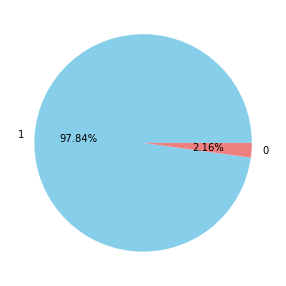

In [102]:
plt.figure(figsize=(10,5))
y_train.value_counts().plot(kind='pie', 
                            colors=['skyblue','lightcoral'], 
                            autopct='%1.2f%%' )
plt.ylabel("")
plt.show()

### Use SMOTE to handle  unbalance data

In [103]:
# !pip install imblearn

In [104]:
from imblearn.over_sampling import SMOTE
x_train, y_train = SMOTE().fit_resample(x_train, y_train)

In [105]:
print(len(x_train))
print(len(y_train))

20712
20712


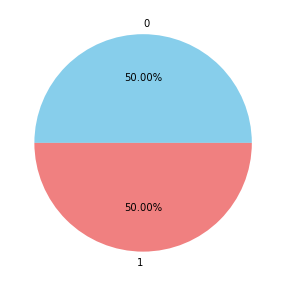

In [106]:
plt.figure(figsize=(10,5))
y_train.value_counts().plot(kind='pie', 
                            colors=['skyblue','lightcoral'], 
                            autopct='%1.2f%%' )
plt.ylabel("")
plt.show()

### [The First Time Calculation of Random Forest (For Feature Extraction)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [107]:
seed = 42

In [108]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = 100
rf = RandomForestClassifier(random_state= seed,
                            n_estimators=n_estimators)

rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [109]:
df = {
    "feature": rf.feature_names_in_,
    "importance": rf.feature_importances_,
}

# table of feature importance
feature_importance = pd.DataFrame(df).sort_values(by=["importance"], ascending=False)
pd.DataFrame(df).sort_values(by=["importance"], ascending=False).head(10)

,feature,importance
5,SalaryMean,0.246621
4,SalaryBonusMean,0.174913
7,ShiftRatio,0.124219
6,WorkOnRestDay,0.120744
8,WorkHourMean,0.056121
2,Turn,0.052299
25,OnBoardMonth_08,0.019533
30,OriRecruitCat_C,0.018175
3,DormAreaCount,0.017400
0,Gender,0.016409


In [110]:
topN = 10

Text(0.5, 1.0, 'Random Forest Feature Importance')

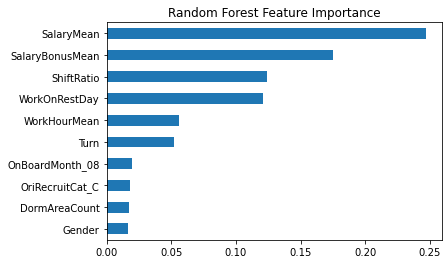

In [111]:
# Plot the 10 most important features
plt.figure()
pd.Series(rf.feature_importances_, 
          rf.feature_names_in_).sort_values(ascending=True)[-topN:].plot.barh(width=0.5,
                                                                              ax=plt.gca())

plt.gca().set_title('Random Forest Feature Importance')

### Reform the X_train & X_test by Top_N features

In [113]:
# use topN features to reform X_train and X_test
x_train = x_train[list(feature_importance["feature"][:topN])]
x_test  =  x_test[list(feature_importance["feature"][:topN])]

### Confusion Matrix & Performance Analysis

In [120]:
predictions = rf2.predict(x_test)
print(confusion_matrix(y_test, predictions))

[[  211   589]
 [  152 10723]]


In [121]:
tn = confusion_matrix(y_test, predictions)[0][0]
fp = confusion_matrix(y_test, predictions)[0][1]
fn = confusion_matrix(y_test, predictions)[1][0]
tp = confusion_matrix(y_test, predictions)[1][1]

In [122]:
import sklearn.metrics

acc =  round(sklearn.metrics.accuracy_score(y_test, predictions), 4)
recall = round(sklearn.metrics.recall_score(y_test, predictions), 4)
f_measure = round( sklearn.metrics.f1_score(y_test, predictions), 4)
precision = round(sklearn.metrics.precision_score(y_test, predictions), 4)

df = {
    "Performance": [acc, recall, precision, f_measure]    
}

In [123]:
pd.DataFrame(df, index=["Acc", "Recall", "Precision", "F1_Score"])

,Performance
Acc,0.936500
Recall,0.986000
Precision,0.947900
F1_Score,0.966600


### Other Algorithms

### [1. Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [124]:
from sklearn.linear_model import LogisticRegression

logit_reg = LogisticRegression(max_iter=300,
                               random_state=seed,
                               solver='liblinear')

logit_reg.fit(x_train, y_train)

LogisticRegression(max_iter=300, random_state=42, solver='liblinear')

In [125]:
logit_reg_prob = logit_reg.predict_proba(x_test)

# Return the mean accuracy on the given test data and labels
print(round(logit_reg.score(x_test, y_test), 4))

0.8855


In [126]:
# AUC
round(sklearn.metrics.roc_auc_score(y_test, logit_reg_prob[::,1]), 4)

0.8226

### [2. Decision Tree](https://scikit-learn.org/stable/modules/tree.html)

In [127]:
from sklearn.tree import DecisionTreeClassifier

In [128]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train, y_train)

dt_prob = dt.predict_proba(x_test)

# Return the mean accuracy on the given test data and labels
print(round(dt.score(x_test, y_test), 4))

0.9224


In [129]:
# AUC
round(sklearn.metrics.roc_auc_score(y_test, dt_prob[::,1]), 4)

0.626

### [3. SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [130]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [131]:
svc = make_pipeline(StandardScaler(),
                    SVC(gamma='auto',
                        kernel="rbf",
                        probability=True,
                        random_state=seed))

svc.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True, random_state=42))])

In [132]:
svc_prob = svc.predict_proba(x_test)

# Return the mean accuracy on the given test data and labels
print(round(svc.score(x_test, y_test), 4))

0.9142


In [133]:
# AUC
round(sklearn.metrics.roc_auc_score(y_test, svc_prob[::,1]), 4)

0.8428

### [4. KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [134]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [135]:
knn_prob = knn.predict_proba(x_test)

# Return the mean accuracy on the given test data and labels
print(round(knn.score(x_test, y_test), 4))

0.8815


In [136]:
# AUC
round(sklearn.metrics.roc_auc_score(y_test, knn_prob[::,1]), 4)

0.6982

### [5. AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [137]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [138]:
ada = AdaBoostClassifier(n_estimators=100, 
                         random_state=seed)
ada.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [139]:
ada_prob = ada.predict_proba(x_test)

# Return the mean accuracy on the given test data and labels
print(round(ada.score(x_test, y_test), 4))

0.916


In [140]:
# AUC
round(sklearn.metrics.roc_auc_score(y_test, ada_prob[::,1]), 4)

0.8611

### [6. Back Propagation](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

In [50]:
from sklearn.neural_network import MLPClassifier

bp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=seed)

In [51]:
bp.fit(x_train, y_train)

bp_prob = bp.predict_proba(x_test)

# Return the mean accuracy on the given test data and labels
print(round(bp.score(x_test, y_test), 4))

0.8705


### Model Evaluation
### [Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)

In [141]:
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold

# Split data into 5 fold
kfold = KFold(n_splits=5, 
              shuffle =True, 
              random_state=seed)

In [142]:
# Let's build different models to train with our data
models = [
    KNeighborsClassifier(n_neighbors=3),
    AdaBoostClassifier(n_estimators=100),
    LogisticRegression(solver='liblinear'),
    DecisionTreeClassifier(random_state=seed),
    SVC(kernel='rbf', gamma='auto', random_state=seed),
    RandomForestClassifier(n_estimators=100, random_state=seed),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=seed),
]

In [143]:
# Validate each model using 5-fold cross validation
mean = []

for model in models:
    result = cross_val_score(model, 
                             x_train, y_train, verbose=2,
                             cv=kfold, scoring="accuracy", n_jobs=-1) # using all processors
    mean.append(result)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

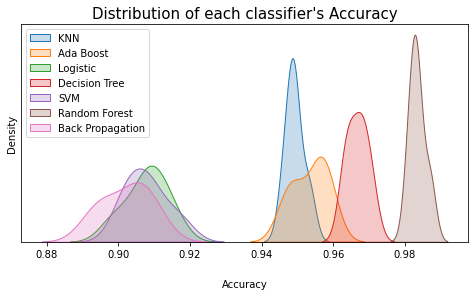

In [145]:
import seaborn as sns

classifiers=['KNN','Ada Boost', 'Logistic','Decision Tree', 'SVM', 'Random Forest', "Back Propagation"]

plt.figure(figsize=(8, 4))

for i in range(len(mean)):
    sns.distplot(mean[i], hist=False, kde_kws={"shade": True})
    
plt.title("Distribution of each classifier's Accuracy", fontsize=15)
plt.legend(classifiers, loc='upper left')
plt.xlabel("Accuracy", labelpad=20)
plt.yticks([])

plt.show()

### ROC Curve

In [56]:
from sklearn.metrics import roc_curve

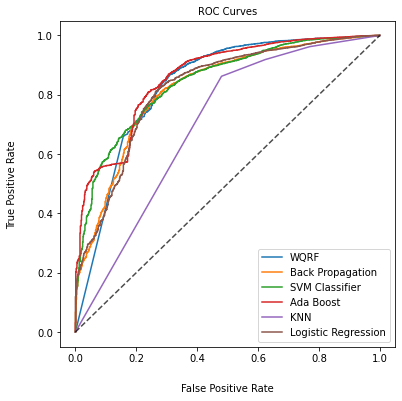

In [146]:
fig = plt.figure(figsize=(6, 6))

# ROC
plt.plot(*roc_curve(y_test, prob_final[:,1])[:2]) # ROC of WQRF
plt.plot(*roc_curve(y_test,    bp_prob[:,1])[:2])
plt.plot(*roc_curve(y_test,   svc_prob[:,1])[:2])
plt.plot(*roc_curve(y_test,   ada_prob[:,1])[:2])
plt.plot(*roc_curve(y_test,   knn_prob[:,1])[:2])
plt.plot(*roc_curve(y_test, logit_reg_prob[:,1])[:2])

# Legend & Position
plt.legend(["WQRF", "Back Propagation", "SVM Classifier", "Ada Boost", "KNN", "Logistic Regression"], loc="lower right")

# Diagonal 
plt.plot((0., 1.), (0., 1.), "--k", alpha =.7)

# Label
plt.xlabel("False Positive Rate", labelpad=20)
plt.ylabel("True Positive Rate",  labelpad=20)

# Title
plt.title("ROC Curves", fontsize=10)
plt.show()